In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Collection

In [2]:
import requests

# URLs of the files
data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/course/module5_course_feature_engineering.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(data_url, 'module5_course_feature_engineering.csv')

Downloaded module5_course_feature_engineering.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/course/module5_course_feature_engineering.csv


In [3]:
data = pd.read_csv('module5_course_feature_engineering.csv')

## Data Preparation - Feature Engineering

In [4]:
data.columns

Index(['datetime', 'holiday', 'temp', 'humidity', 'windspeed', 'pressure',
       'count'],
      dtype='object')

In [5]:
data

,datetime,holiday,temp,humidity,windspeed,pressure,count
0,2011-01-01 00:00:00,0,9.84,81,0.0000,1003.968602,16
1,2011-01-01 01:00:00,0,9.02,80,0.0000,1004.338980,40
2,2011-01-01 02:00:00,0,9.02,80,0.0000,1004.649640,32
3,2011-01-01 03:00:00,0,9.84,75,0.0000,1005.179412,13
4,2011-01-01 04:00:00,0,9.84,75,0.0000,1005.567640,1
...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,15.58,50,26.0027,1003.366120,336
10882,2012-12-19 20:00:00,0,14.76,57,15.0013,1005.060022,241
10883,2012-12-19 21:00:00,0,13.94,61,15.0013,1000.792171,168
10884,2012-12-19 22:00:00,0,13.94,61,6.0032,1002.540680,129


In [6]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [8]:
def compute_weather(pressure, temp, humidity, windspeed, date_time):
    # Base pressure (in hPa)
    base_pressure = 1013.25
    
    # Temperature effect
    temp_effect = -0.1 * (temp - 15)
    
    # Humidity effect
    humidity_effect = -0.05 * (humidity - 50)
    
    # Wind effect
    wind_effect = -0.2 * windspeed
    
    # Seasonal effect
    day_of_year = date_time.timetuple().tm_yday
    seasonal_effect = 3 * np.sin(2 * np.pi * day_of_year / 365)
    
    # Diurnal effect
    hour = date_time.hour
    diurnal_effect = 1.5 * np.sin(2 * np.pi * (hour - 4) / 24)
    
    # Remove all effects except weather effect
    weather_effect = pressure - (base_pressure + temp_effect + humidity_effect + 
                                 wind_effect + seasonal_effect + diurnal_effect)
    
    # Determine weather category based on weather effect
    if weather_effect >= 1:
        return 1  # Clear
    elif -2 <= weather_effect < 1:
        return 2  # Cloudy
    elif -5 <= weather_effect < -2:
        return 3  # Light rain/snow
    else:
        return 4  # Heavy rain/storm

# New transformation 2: Compute feels_like temperature
def compute_feels_like(temp, windspeed, humidity):
    feels_like = np.zeros_like(temp)
    
    # Heat index calculation (for high temperatures)
    mask_hi = temp > 27
    hi = -8.78469475556 + 1.61139411 * temp + 2.33854883889 * humidity
    hi += -0.14611605 * temp * humidity - 0.012308094 * temp**2
    hi += -0.0164248277778 * humidity**2 + 0.002211732 * temp**2 * humidity
    hi += 0.00072546 * temp * humidity**2 - 0.000003582 * temp**2 * humidity**2
    feels_like[mask_hi] = hi[mask_hi]
    
    # Wind chill calculation (for low temperatures with wind)
    mask_wc = (temp <= 10) & (windspeed > 4.8)
    wc = 13.12 + 0.6215 * temp - 11.37 * windspeed**0.16 + 0.3965 * temp * windspeed**0.16
    feels_like[mask_wc] = wc[mask_wc]
    
    # If neither condition is met, return the actual temperature
    mask_normal = ~(mask_hi | mask_wc)
    feels_like[mask_normal] = temp[mask_normal]
    
    return feels_like

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Base features
base_features = ['holiday', 'temp', 'humidity', 'windspeed', 'pressure']

# 1. Time-based Decomposition
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek

# 2. Aggregation
data['avg_temp_by_hour'] = data.groupby('hour')['temp'].transform('mean')
data['avg_temp_by_month'] = data.groupby('month')['temp'].transform('mean')

# 3. Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(data[['temp', 'humidity']])
poly_feature_names = poly.get_feature_names_out(['temp', 'humidity'])
data[poly_feature_names] = poly_features

# 4. Custom Transformations

data['computed_weather'] = data.apply(lambda row: compute_weather(
    row['pressure'], row['temp'], row['humidity'], row['windspeed'], row['datetime']), axis=1)
data['feels_like'] = compute_feels_like(data['temp'], data['windspeed'], data['humidity'])

# 5. Log Transformation
data['log_windspeed'] = np.log1p(data['windspeed'])

# 6. Time-series Transformations
data['rolling_avg_count'] = data['count'].rolling(window=24, min_periods=1).mean()
data['rolling_avg_temp'] = data['temp'].rolling(window=24, min_periods=1).mean()

# 7. Lag Features (avoiding target leakage)
for lag in [1, 2, 3, 24]:  # 1 hour, 2 hours, 3 hours, and 24 hours (1 day) ago
    data[f'count_lag_{lag}'] = data['count'].shift(lag)

lag_features = [f'count_lag_{lag}' for lag in [1, 2, 3, 24]]

Base - Mean Train MSE: 11960.56, Mean Test MSE: 28268.62
Decomposition - Mean Train MSE: 9528.38, Mean Test MSE: 19642.11
Aggregation - Mean Train MSE: 10252.33, Mean Test MSE: 25053.87
Polynomial - Mean Train MSE: 11617.00, Mean Test MSE: 27769.27
Custom - Mean Train MSE: 11450.81, Mean Test MSE: 25633.39
Log Transform - Mean Train MSE: 12014.26, Mean Test MSE: 28198.73
Time-series - Mean Train MSE: 10653.01, Mean Test MSE: 22876.16
Lag - Mean Train MSE: 3092.27, Mean Test MSE: 6025.12
Combined - Mean Train MSE: 2988.43, Mean Test MSE: 5878.20


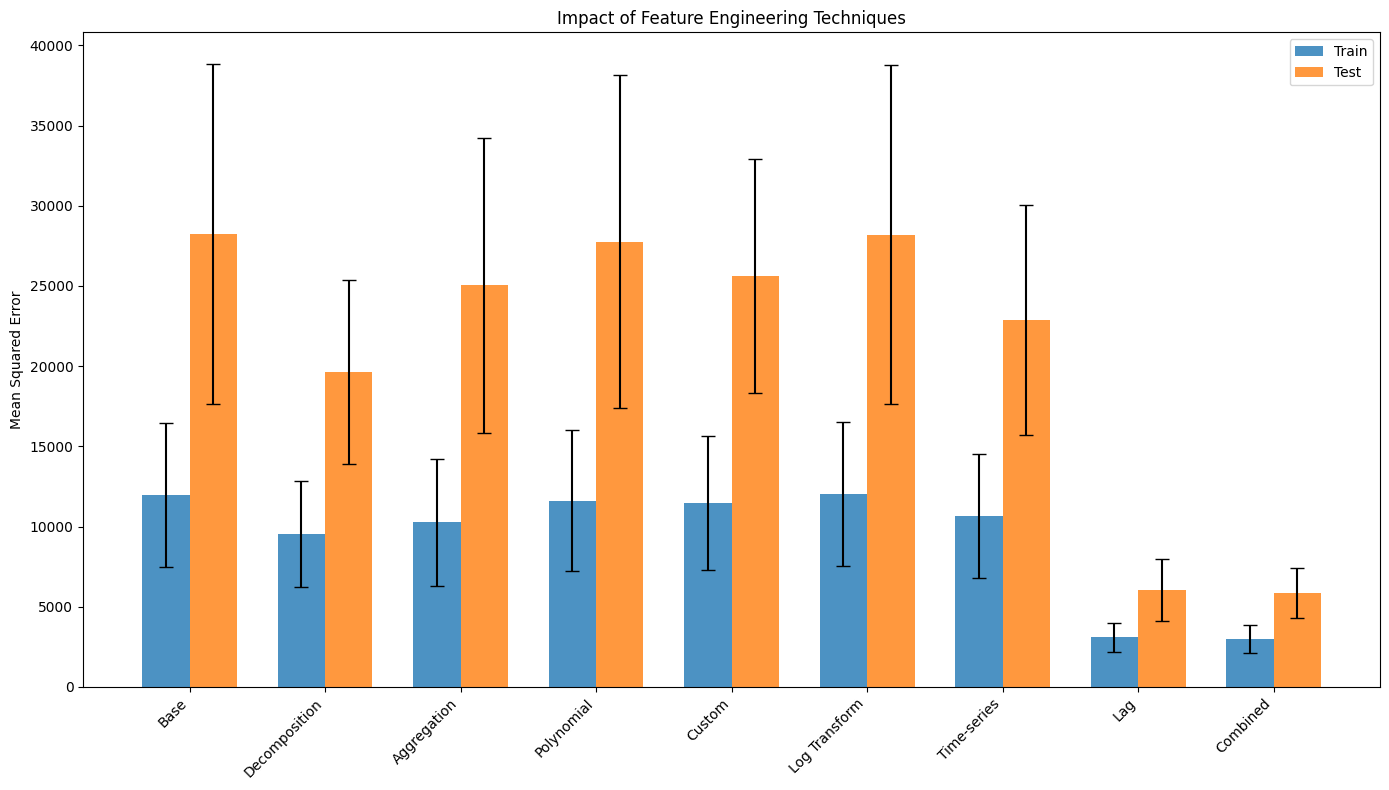

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

def evaluate_features(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    model = LinearRegression()
    
    train_scores = []
    test_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        train_scores.append(train_mse)
        test_scores.append(test_mse)
    
    return train_scores, test_scores

# Define feature sets
techniques = {
    'Base': base_features,
    'Decomposition': base_features + ['year', 'month', 'day', 'hour', 'day_of_week'],
    'Aggregation': base_features + ['avg_temp_by_hour', 'avg_temp_by_month'],
    'Polynomial': base_features + list(poly_feature_names),
    'Custom': base_features + ['computed_weather', 'feels_like'],
    'Log Transform': ['holiday', 'temp', 'humidity', 'log_windspeed', 'pressure'],
    'Time-series': base_features + ['rolling_avg_count', 'rolling_avg_temp'],
    'Lag': base_features + lag_features,
    'Combined': ['holiday', 'temp', 'computed_weather', 'humidity', 'log_windspeed', 'pressure',
                 'year', 'month', 'day', 'hour', 'day_of_week', 'avg_temp_by_hour', 'avg_temp_by_month',
                 'rolling_avg_count', 'rolling_avg_temp', 'feels_like'] + lag_features
}

results = {}
for name, features in techniques.items():
    X = data[features].fillna(data[features].mean())
    y = data['count']
    
    train_scores, test_scores = evaluate_features(X, y)
    results[name] = {
        'train': train_scores,
        'test': test_scores
    }
    print(f"{name} - Mean Train MSE: {np.mean(train_scores):.2f}, Mean Test MSE: {np.mean(test_scores):.2f}")

# Visualization
plt.figure(figsize=(14, 8))

x = np.arange(len(techniques))
width = 0.35

train_means = [np.mean(results[tech]['train']) for tech in techniques]
test_means = [np.mean(results[tech]['test']) for tech in techniques]

train_errors = [np.std(results[tech]['train']) for tech in techniques]
test_errors = [np.std(results[tech]['test']) for tech in techniques]

plt.bar(x - width/2, train_means, width, label='Train', yerr=train_errors, capsize=5, alpha=0.8)
plt.bar(x + width/2, test_means, width, label='Test', yerr=test_errors, capsize=5, alpha=0.8)

plt.ylabel('Mean Squared Error')
plt.title('Impact of Feature Engineering Techniques')
plt.xticks(x, techniques.keys(), rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()